# Project 3 INF264

Author: Johanna Jøsang (fak006)

In [1]:
# Imports
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import random
import timeit
from pprint import pprint
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# LeNet-5 imports
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils

In [2]:
# Load data
label_data = np.genfromtxt('handwritten_digits_labels.csv', delimiter=',')
image_data = np.genfromtxt('handwritten_digits_images.csv', delimiter=',')
image_data = image_data.reshape(image_data.shape[0], 28, 28) # reshaping data

## Visualisation and preprocessing

In order to get a better understanding of the data I have been given, I start by gathering information about it.
First I would like to get a look at the shape of the data.

In [3]:
print("Label data shape:", label_data.shape)
print("Image data shape:", image_data.shape)

Label data shape: (70000,)
Image data shape: (70000, 28, 28)


As expected, the label dataset is a simple array with 70000 values, while the image dataset has 70000 2d arrays represetning the digit image.

Just to visalize the data for myself I print out a random image and its corresponding label.

At index 66473 there is a 9.0


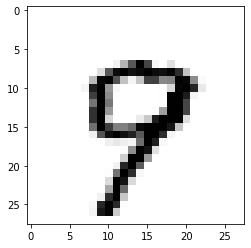

In [4]:
data_index = random.randint(0, label_data.size)
img = image_data[data_index]
plt.imshow(img, cmap="Greys")
print("At index", data_index, "there is a", label_data[data_index])

### Digit distribution

In order to find out how the data is distributed between the 10 digits, I print out the frequency, percentages and a histogram to see the distribution.

In [5]:
# Count number of examples for each digit
label_counter = collections.Counter(label_data)
print(label_counter)

# Print out the percentages for each digit
label_data_size = label_data.size
for i in range(10):
    percentage = (label_counter[i] / label_data_size) * 100
    print(i, ": ", "%.2f" % percentage, "%")
    
# Print min and max, which can easily be count ince label_counter is sorted by frequency
print("Min freq is 5 with", "%.2f" % ((label_counter[5] / label_data_size) * 100), "%")
print("Max freq is 1 with", "%.2f" % ((label_counter[1] / label_data_size) * 100), "%")

Counter({1.0: 7877, 7.0: 7293, 3.0: 7141, 2.0: 6990, 9.0: 6958, 0.0: 6903, 6.0: 6876, 8.0: 6825, 4.0: 6824, 5.0: 6313})
0 :  9.86 %
1 :  11.25 %
2 :  9.99 %
3 :  10.20 %
4 :  9.75 %
5 :  9.02 %
6 :  9.82 %
7 :  10.42 %
8 :  9.75 %
9 :  9.94 %
Min freq is 5 with 9.02 %
Max freq is 1 with 11.25 %


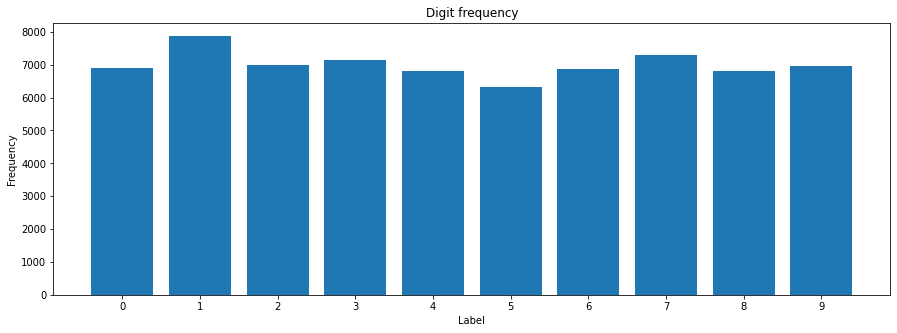

In [6]:
# Histogram
names = list(label_counter.keys())
values = list(label_counter.values())
fig = plt.figure(figsize=(15,5))
plt.bar(names, values)
plt.xticks(np.arange(0, 10))
plt.ylabel('Frequency')
plt.xlabel('Label')
plt.title("Digit frequency");

All digits have about 10% of the data, so it does not seem like the dataset needs to be balanced. The least frequent digit was 5 (9.02 %) and the most frequent was 1 (11.25 %). If our trained classifiers become much worse at categorizing 5s compared to 1s then we can perhaps go back and balance the data.

In [3]:
seed = 123
X_train_val, X_test, y_train_val, y_test = train_test_split(image_data, label_data, test_size=0.1, shuffle=True, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=seed)


In [4]:
def reshape_3d_to_2d(data_3d):
    number_of_samples, x_dim, y_dim = data_3d.shape
    dataset_2d = data_3d.reshape((number_of_samples,x_dim*y_dim))
    return dataset_2d

X_train_2d = reshape_3d_to_2d(X_train)
X_val_2d = reshape_3d_to_2d(X_val)
X_train_val_2d = reshape_3d_to_2d(X_train_val)

In [9]:
clf = RandomForestClassifier()
clf.fit(X_train_2d, y_train)

#print(clf.predict([[0, 0, 0, 0]]))

RandomForestClassifier()

In [10]:
X_val_2d = reshape_3d_to_2d(X_val)
print(clf.score(X_val_2d, y_val))

0.9662698412698413


In [11]:
def kFold_cross_validation(X_train_val, y_train_val):
    kf = KFold(n_splits=5)
    score_count = []
    iteration_counter = 1
    for train_index, test_index in kf.split(X_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[test_index]
        y_train, y_val = y_train_val[train_index], y_train_val[test_index]
        clf.fit(X_train, y_train)
        iteration_score = clf.score(X_val, y_val)
        print("Iteration", iteration_counter, "score:", iteration_score)
        score_count.append(iteration_score)
    mean_score = np.mean(score_count)
    print("Mean score:", mean_score)
    return mean_score

In [12]:
X_train_val_2d = reshape_3d_to_2d(X_train_val)

mean_1 = kFold_cross_validation(X_train_val_2d, y_train_val)

Iteration 1 score: 0.9705555555555555
Iteration 1 score: 0.9667460317460318
Iteration 1 score: 0.9646031746031746
Iteration 1 score: 0.9673809523809523
Iteration 1 score: 0.9696031746031746
Mean score: 0.9677777777777777


In [13]:
print(cross_val_score(clf, X_train_val_2d, y_train_val))

[0.97015873 0.96492063 0.96730159 0.96706349 0.96809524]


In [14]:
print(np.mean([0.965, 0.96865079, 0.9681746, 0.96801587, 0.96785714]))

0.96753968


In [15]:
print(clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [20]:
val_acc_at_depth = {} # Dictionary for keeping track of depth vs accuracy
train_acc_at_depth = {} # Dictionary for keeping track of depth vs accuracy
for i in range(1,30):
    clf = RandomForestClassifier(max_depth = i)
    #cross_val_scores = cross_val_score(clf, X_train_val_2d, y_train_val)
    clf.fit(X_train_2d, y_train)
    train_score = clf.score(X_train_2d, y_train)
    val_score = clf.score(X_val_2d, y_val)
    #mean_cross_val_score = np.mean(cross_val_scores)
    print("Precision at depth", i , "is val:", val_score, "train", train_score)
    #acc_at_depth[i] = mean_cross_val_score 
    train_acc_at_depth[i] = train_score
    val_acc_at_depth[i] = val_score

Precision at depth 1 is val: 0.5082539682539683 train 0.5174603174603175
Precision at depth 2 is val: 0.6359523809523809 train 0.6353968253968254
Precision at depth 3 is val: 0.7478571428571429 train 0.7492063492063492
Precision at depth 4 is val: 0.8105555555555556 train 0.8116666666666666
Precision at depth 5 is val: 0.858015873015873 train 0.8636904761904762
Precision at depth 6 is val: 0.8861904761904762 train 0.8919444444444444
Precision at depth 7 is val: 0.9075396825396825 train 0.9176587301587301
Precision at depth 8 is val: 0.9245238095238095 train 0.9349206349206349
Precision at depth 9 is val: 0.9367460317460318 train 0.9515277777777778
Precision at depth 10 is val: 0.9449206349206349 train 0.966468253968254
Precision at depth 11 is val: 0.9523015873015873 train 0.9789285714285715
Precision at depth 12 is val: 0.9565079365079365 train 0.9888492063492064
Precision at depth 13 is val: 0.9602380952380952 train 0.993452380952381
Precision at depth 14 is val: 0.9619047619047619 t

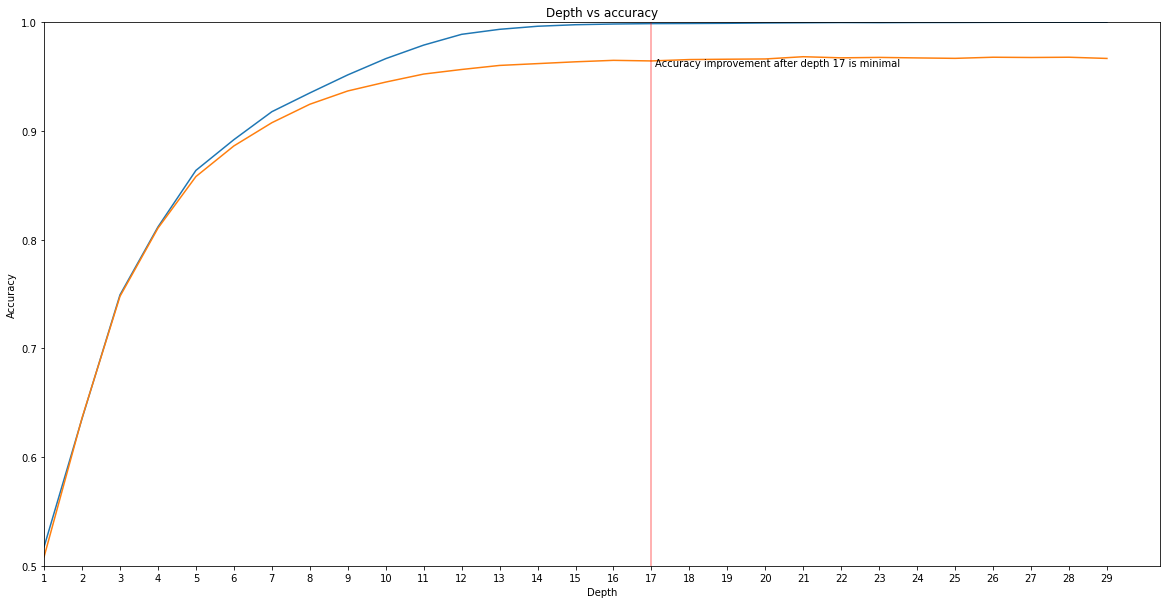

In [26]:
x = train_acc_at_depth.keys()
train_y = train_acc_at_depth.values()
val_y = val_acc_at_depth.values()
fig = plt.figure(figsize=(20,10))
plt.plot(x,train_y)
plt.plot(x,val_y)
plt.axvline(x=17, ymin=0, ymax=1, color = 'r', alpha = 0.4)
plt.text(17.1, 0.96, "Accuracy improvement after depth 17 is minimal")
plt.xlim(left=13)
plt.ylim(bottom=0.5, top = 1)
plt.title("Depth vs accuracy")
plt.xticks(np.arange(1, 30, 1))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

The graph above only examines the range between acciracies 0.9-0.97. We can now see that after depth 17, the accuracy of the classifier does not really improve by much. Hence, we chose depth = 17 for our random forest classifier.

### Impurity measure
We will use k-fold cross valudation to check if gini or entropy is best as impurity measure.

In [25]:
clf = RandomForestClassifier(criterion = 'gini', max_depth = 17)
cross_val_score_gini = np.mean(cross_val_score(clf, X_train_val_2d, y_train_val))
print(cross_val_score_gini)
clf = RandomForestClassifier(criterion = 'entropy', max_depth = 17)
cross_val_score_entropy = np.mean(cross_val_score(clf, X_train_val_2d, y_train_val))
print(cross_val_score_entropy)

0.9657460317460318


KeyboardInterrupt: 

In [ ]:
diff_percentage = (np.abs(cross_val_score_gini-cross_val_score_entropy)/ ((cross_val_score_entropy+cross_val_score_gini)/2)) *100
print("Accuracy difference between gini and entropy:", "%.2f" % diff_percentage, "%")

While entropy has slightly higher accuracy than gini, the difference is only 0.05%. Since gini requires less computation than entropy, it will be chosen as impurity measure.


### Number of trees
Now we will take a look at the optimal number of trees required. First we will iterate over 10 segments of 50, to get a rough idea of where the optimal number of trees lies.

In [27]:
val_acc_ntrees = {} # Dictionary for keeping track of number of trees and accuracy
train_acc_ntrees = {} # Dictionary for keeping track of number of trees and accuracy

for i in range(50, 400, 50):
    clf = RandomForestClassifier(n_estimators = i, criterion = 'gini', max_depth = 17)
    clf.fit(X_train_2d, y_train)
    train_score = clf.score(X_train_2d, y_train)
    val_score = clf.score(X_val_2d, y_val)
    print("Precision at tree number", i , "is val:", val_score, " train:", train_score)
    val_acc_ntrees[i] = val_score
    train_acc_ntrees[i] = train_score 

Precision at tree number 50 is: 0.964047619047619
Precision at tree number 100 is: 0.9646031746031746
Precision at tree number 150 is: 0.9665873015873016
Precision at tree number 200 is: 0.966031746031746
Precision at tree number 250 is: 0.9665873015873016
Precision at tree number 300 is: 0.9676190476190476
Precision at tree number 350 is: 0.9665079365079365


dict_keys([50, 100, 150, 200, 250, 300, 350])
dict_values([0.964047619047619, 0.9646031746031746, 0.9665873015873016, 0.966031746031746, 0.9665873015873016, 0.9676190476190476, 0.9665079365079365])


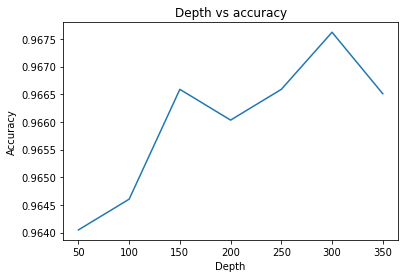

In [28]:
x = val_acc_ntrees.keys()
val_y = val_acc_ntrees.values()
train_y train_acc_ntrees.values()
print(x)
print(val_y)
print(train_y)
#fig = plt.figure(figsize=(20,10))
plt.plot(x,y)
#plt.axvline(x=17, ymin=0, ymax=1, color = 'r', alpha = 0.4)
#plt.text(17.1, 0.96, "Accuracy improvement after depth 17 is minimal")
#plt.xlim(left=13)
#plt.ylim(bottom=0.9, top = 0.97)
plt.title("Depth vs accuracy")
#plt.xticks(np.arange(1, 30, 1))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

In [29]:
val_acc_ntrees2 = {} # Dictionary for keeping track of number of trees and accuracy
train_acc_ntrees2 = {} # Dictionary for keeping track of number of trees and accuracy
runtime_ntrees = {}
for i in range(25, 400, 25):
    clf = RandomForestClassifier(n_estimators = i, criterion = 'gini', max_depth = 17)
    start = timeit.default_timer()
    clf.fit(X_train_2d, y_train)
    stop = timeit.default_timer()
    #print('Runtime for trees', i, " is:", stop - start, "seconds")  
    runtime_ntrees[i] = stop - start
    val_score = clf.score(X_val_2d, y_val)
    train_score = clf.score(X_train_2d, y_train)
    print("Precision at tree number", i , "is val:", val_score, " train:", train_score)
    val_acc_ntrees2[i] = val_score 
    train_acc_ntrees2[i] = train_score

Precision at tree number 25 is: 0.9581746031746031
Precision at tree number 50 is: 0.964047619047619
Precision at tree number 75 is: 0.9648412698412698
Precision at tree number 100 is: 0.964047619047619
Precision at tree number 125 is: 0.966031746031746
Precision at tree number 150 is: 0.9665873015873016
Precision at tree number 175 is: 0.9673809523809523
Precision at tree number 200 is: 0.967936507936508
Precision at tree number 225 is: 0.9673015873015873
Precision at tree number 250 is: 0.9669047619047619
Precision at tree number 275 is: 0.9661111111111111
Precision at tree number 300 is: 0.9671428571428572
Precision at tree number 325 is: 0.9676984126984127
Precision at tree number 350 is: 0.9673015873015873
Precision at tree number 375 is: 0.9669047619047619


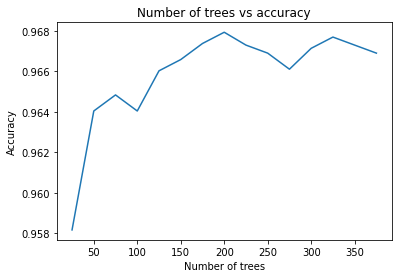

In [30]:
x = val_acc_ntrees2.keys()
val_y = val_acc_ntrees2.values()
train_y = train_acc_ntrees2.values()
plt.plot(x,val_y)
plt.plot(x,train_y)
plt.title("Number of trees vs accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

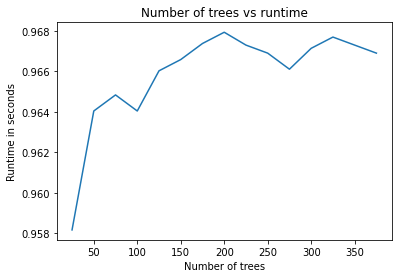

In [31]:
r_x = runtime_ntrees.keys()
r_y = runtime_ntrees.values()
plt.plot(x,y)
plt.title("Number of trees vs runtime")
plt.ylabel('Runtime in seconds')
plt.xlabel('Number of trees')
plt.show()

### Maximum features

In [32]:
val_nfeatures_acc = {}
train_nfeatures_acc = {}
runtime_nfeatures = {}
for i in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    clf = RandomForestClassifier(n_estimators = 125, criterion = 'gini', max_depth = 17, max_features = i)
    start = timeit.default_timer()
    clf.fit(X_train_2d, y_train)
    stop = timeit.default_timer()
    runtime_nfeatures[i] = stop - start
    val_score = clf.score(X_val_2d, y_val)
    train_score = clf.score(X_train_2d, y_train)
    print("Precision at", i , "features is val:", val_score, " train:", train_score)
    val_nfeatures_acc[i] = val_score
    train_nfeatures_acc[i] = train_score 

Precision at 1 features is val: 0.9288888888888889  train: 0.9735119047619047
Precision at 2 features is val: 0.943015873015873  train: 0.9890873015873016
Precision at 4 features is val: 0.954047619047619  train: 0.9970039682539683
Precision at 8 features is val: 0.9614285714285714  train: 0.9986309523809523
Precision at 16 features is val: 0.9653174603174604  train: 0.9989484126984127
Precision at 32 features is val: 0.966984126984127  train: 0.9987698412698413
Precision at 64 features is val: 0.9661904761904762  train: 0.9980357142857142
Precision at 128 features is val: 0.9653174603174604  train: 0.9973015873015874
Precision at 256 features is val: 0.9632539682539683  train: 0.9966071428571428
Precision at 512 features is val: 0.9608730158730159  train: 0.9964087301587301


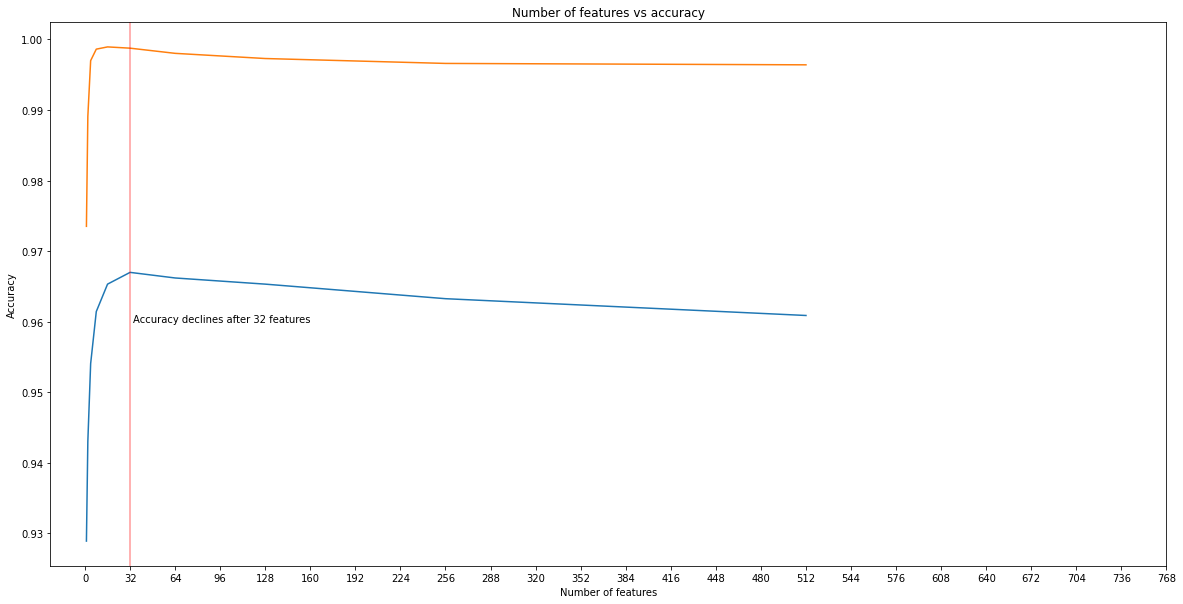

In [33]:
nfeatures_x = val_nfeatures_acc.keys()
val_nfeatures_y = val_nfeatures_acc.values()
train_nfeatures_y = train_nfeatures_acc.values()
fig = plt.figure(figsize=(20,10))
plt.plot(nfeatures_x,val_nfeatures_y)
plt.plot(nfeatures_x,train_nfeatures_y)
plt.title("Number of features vs accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.ylim(bottom=0.5, top = 1)
plt.axvline(x=32, ymin=0, ymax=1, color = 'r', alpha = 0.4)
plt.text(34, 0.96, "Accuracy declines after 32 features")
plt.xticks(np.arange(0, 782, 32))
plt.show()

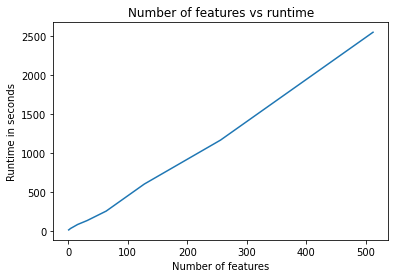

In [34]:
r_x = runtime_nfeatures.keys()
r_y = runtime_nfeatures.values()
plt.plot(r_x,r_y)
plt.title("Number of features vs runtime")
plt.ylabel('Runtime in seconds')
plt.xlabel('Number of features')
plt.show()

In [36]:
val_nfeatures2_acc = {}
train_nfeatures2_acc = {}
for i in range(16, 64, 4):
    clf = RandomForestClassifier(n_estimators = 125, criterion = 'gini', max_depth = 17, max_features = i)
    clf.fit(X_train_2d, y_train)
    val_score = clf.score(X_val_2d, y_val)
    train_score = clf.score(X_train_2d, y_train)
    print("Precision at", i , "features is val:", val_score, " train:", train_score)
    val_nfeatures2_acc[i] = val_score 
    train_nfeatures2_acc[i] = train_score 

Precision at 16 features is val: 0.9639682539682539  train: 0.998968253968254
Precision at 20 features is val: 0.9654761904761905  train: 0.9988690476190476
Precision at 24 features is val: 0.9664285714285714  train: 0.9987698412698413
Precision at 28 features is val: 0.9647619047619047  train: 0.998829365079365
Precision at 32 features is val: 0.966031746031746  train: 0.9985912698412699
Precision at 36 features is val: 0.9670634920634921  train: 0.9984722222222222
Precision at 40 features is val: 0.9668253968253968  train: 0.9985515873015873
Precision at 44 features is val: 0.9663492063492064  train: 0.9984920634920635
Precision at 48 features is val: 0.9653174603174604  train: 0.998234126984127
Precision at 52 features is val: 0.9656349206349206  train: 0.9982142857142857
Precision at 56 features is val: 0.9657936507936508  train: 0.998234126984127
Precision at 60 features is val: 0.9661111111111111  train: 0.9980357142857142


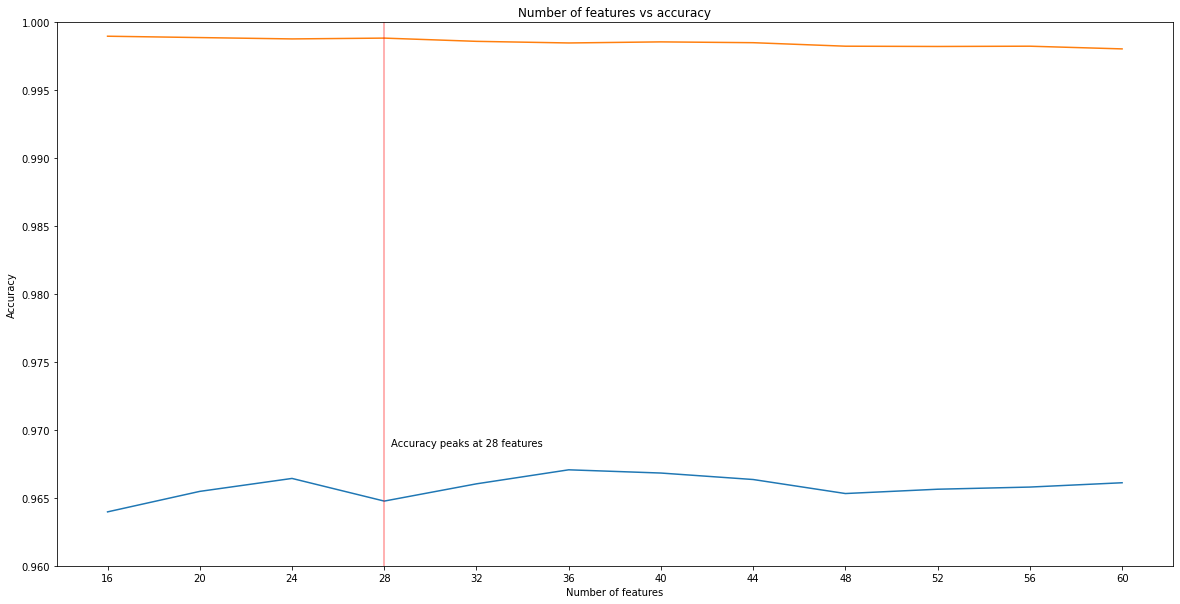

In [41]:
nfeatures2_x = val_nfeatures2_acc.keys()
val_nfeatures2_y = val_nfeatures2_acc.values()
train_nfeatures2_y = train_nfeatures2_acc.values()
fig = plt.figure(figsize=(20,10))
plt.plot(nfeatures2_x,val_nfeatures2_y)
plt.plot(nfeatures2_x,train_nfeatures2_y)
plt.title("Number of features vs accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.ylim(bottom=0.96, top = 1)
plt.axvline(x=28, ymin=0, ymax=1, color = 'r', alpha = 0.4)
plt.text(28.3, 0.9688, "Accuracy peaks at 28 features")
plt.xticks(np.arange(16, 64, 4))
plt.show()

# Fak det shit I'm doing gridsearch

In [5]:
rf = RandomForestClassifier(random_state = 123)
from pprint import pprint
print('Possible parameters:')
pprint(rf.get_params())

Possible parameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


In [6]:
n_estimators = range(50, 400, 50)
max_features = ['auto', 'sqrt']
max_depth = range(10, 31, 5)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': range(10, 31, 5),
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': range(50, 400, 50)}


In [7]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=123, n_jobs = -1, return_train_score=True)
rf_random.fit(X_train_val_2d, y_train_val)
print("Started")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 63.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 123.1min finished


Started


In [8]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30}

## Convolutional Neural Network (LeNet-5)

In [64]:
# Preprocessing

# Make image data 4-dimensional
X_train_val_4d = X_train_val.reshape(X_train_val.shape[0], 28, 28, 1)
X_train_4d = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val_4d = X_val.reshape(X_val.shape[0], 28, 28, 1)

# convert label data to one-hot encoding
y_train_val_onehot = np_utils.to_categorical(y_train_val, 10)
y_train_onehot = np_utils.to_categorical(y_train, 10)
y_val_onehot = np_utils.to_categorical(y_val, 10)

In [70]:
def leNet_5_setup(activation_function, learning_rate):    
    # Initialize an empty sequential model
    leNet_model = Sequential()
    # Convolutional Layer
    leNet_model.add(Conv2D(filters = 6, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, input_shape=(28,28,1), padding= 'same'))
    # Pooling
    leNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding= 'same'))
    #Convolutional Layer
    leNet_model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, padding= 'valid'))
    # Pooling
    leNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding= 'valid'))
    # Connected Convolutional Layer
    leNet_model.add(Conv2D(120, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, padding= 'valid'))
    # Flattening
    leNet_model.add(Flatten())
    # Fully Connected Layer
    leNet_model.add(Dense(84, activation= activation_function))
    #Output Layer with softmax activation
    leNet_model.add(Dense(10, activation= 'softmax'))
    # Compile the model
    #leNet_model.compile(loss= 'categorical_crossentropy', optimizer= 'SGD', metrics=['accuracy']) 
    # learning rate has to be increased to 0.01, otherwise the CNN sometimes ends in a local minimum
    leNet_model.compile(loss= 'categorical_crossentropy', optimizer = SGD(lr = learning_rate), metrics=['accuracy']) 
    #leNet_model.compile(loss= 'categorical_crossentropy', optimizer = SGD(lr = 0.01, momentum = 0.9), metrics=['accuracy']) 

    return leNet_model

In [ ]:
# Test run of LeNet-5 model
batch_size = 32
epocs = 8

In [13]:
leNet_model_tanh = leNet_5_setup(activation_function = 'tanh')
tanh_leNet_history = leNet_model_tanh.fit(X_train_4d, y_train_onehot, validation_data=(X_val_4d, y_val_onehot),  shuffle=False, batch_size = batch_size, epochs = epocs)

Epoch 1/8
1575/1575 [==============================] - 107s 68ms/step - loss: 0.1910 - accuracy: 0.9466 - val_loss: 0.0942 - val_accuracy: 0.9744
Epoch 2/8
1575/1575 [==============================] - 108s 68ms/step - loss: 0.0734 - accuracy: 0.9795 - val_loss: 0.0697 - val_accuracy: 0.9798
Epoch 3/8
1575/1575 [==============================] - 108s 68ms/step - loss: 0.0556 - accuracy: 0.9848 - val_loss: 0.0606 - val_accuracy: 0.9825
Epoch 4/8
1575/1575 [==============================] - 106s 67ms/step - loss: 0.0453 - accuracy: 0.9880 - val_loss: 0.0554 - val_accuracy: 0.9842
Epoch 5/8
1575/1575 [==============================] - 106s 67ms/step - loss: 0.0388 - accuracy: 0.9898 - val_loss: 0.0523 - val_accuracy: 0.9848
Epoch 6/8
1575/1575 [==============================] - 107s 68ms/step - loss: 0.0339 - accuracy: 0.9913 - val_loss: 0.0496 - val_accuracy: 0.9855
Epoch 7/8
1575/1575 [==============================] - 106s 67ms/step - loss: 0.0303 - accuracy: 0.9922 - val_loss: 0.0486 -

In [14]:
leNet_model_relu = leNet_5_setup(activation_function = 'relu')
relu_leNet_history = leNet_model_relu.fit(X_train_4d, y_train_onehot, validation_data=(X_val_4d, y_val_onehot), shuffle=False, batch_size = batch_size, epochs = epocs, verbose = 1)

Epoch 1/8
1575/1575 [==============================] - 103s 65ms/step - loss: 0.4580 - accuracy: 0.9085 - val_loss: 0.0868 - val_accuracy: 0.9729
Epoch 2/8
1575/1575 [==============================] - 116s 73ms/step - loss: 0.0681 - accuracy: 0.9793 - val_loss: 0.0593 - val_accuracy: 0.9821
Epoch 3/8
1575/1575 [==============================] - 117s 74ms/step - loss: 0.0425 - accuracy: 0.9874 - val_loss: 0.0624 - val_accuracy: 0.9813
Epoch 4/8
1575/1575 [==============================] - 116s 74ms/step - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.0604 - val_accuracy: 0.9822
Epoch 5/8
1575/1575 [==============================] - 116s 73ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.0730 - val_accuracy: 0.9796
Epoch 6/8
1575/1575 [==============================] - 116s 73ms/step - loss: 0.0153 - accuracy: 0.9955 - val_loss: 0.0668 - val_accuracy: 0.9825
Epoch 7/8
1575/1575 [==============================] - 115s 73ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0695 -

In [21]:
leNet_model_sigmoid = leNet_5_setup(activation_function = 'sigmoid')
sigmoid_leNet_history = leNet_model_sigmoid.fit(X_train_4d, y_train_onehot, validation_data=(X_val_4d, y_val_onehot), shuffle=False, batch_size = batch_size, epochs = epocs, verbose = 1)

Epoch 1/8
1575/1575 [==============================] - 156s 99ms/step - loss: 2.3055 - accuracy: 0.1053 - val_loss: 2.3027 - val_accuracy: 0.1138
Epoch 2/8
1575/1575 [==============================] - 172s 109ms/step - loss: 2.3037 - accuracy: 0.1063 - val_loss: 2.3026 - val_accuracy: 0.1138
Epoch 3/8
1575/1575 [==============================] - 176s 112ms/step - loss: 2.3037 - accuracy: 0.1066 - val_loss: 2.3025 - val_accuracy: 0.1138
Epoch 4/8
1575/1575 [==============================] - 172s 109ms/step - loss: 2.3035 - accuracy: 0.1069 - val_loss: 2.3022 - val_accuracy: 0.1138
Epoch 5/8
1575/1575 [==============================] - 134s 85ms/step - loss: 2.3034 - accuracy: 0.1085 - val_loss: 2.3013 - val_accuracy: 0.1138
Epoch 6/8
1575/1575 [==============================] - 170s 108ms/step - loss: 2.3023 - accuracy: 0.1108 - val_loss: 2.3007 - val_accuracy: 0.1140
Epoch 7/8
1575/1575 [==============================] - 129s 82ms/step - loss: 2.2957 - accuracy: 0.1235 - val_loss: 2.28

In [24]:
leNet_model_softmax = leNet_5_setup(activation_function = 'softmax')
softmax_leNet_history = leNet_model_softmax.fit(X_train_4d, y_train_onehot, validation_data=(X_val_4d, y_val_onehot), shuffle=False, batch_size = batch_size, epochs = epocs, verbose = 1)

Epoch 1/8
1575/1575 [==============================] - 227s 144ms/step - loss: 2.3016 - accuracy: 0.1114 - val_loss: 2.3012 - val_accuracy: 0.1138
Epoch 2/8
1575/1575 [==============================] - 268s 170ms/step - loss: 2.3013 - accuracy: 0.1123 - val_loss: 2.3012 - val_accuracy: 0.1138
Epoch 3/8
1575/1575 [==============================] - 272s 172ms/step - loss: 2.3013 - accuracy: 0.1123 - val_loss: 2.3012 - val_accuracy: 0.1138
Epoch 4/8
1575/1575 [==============================] - 253s 161ms/step - loss: 2.3013 - accuracy: 0.1123 - val_loss: 2.3012 - val_accuracy: 0.1138
Epoch 5/8
1575/1575 [==============================] - 192s 122ms/step - loss: 2.3013 - accuracy: 0.1123 - val_loss: 2.3012 - val_accuracy: 0.1138
Epoch 6/8
1575/1575 [==============================] - 195s 124ms/step - loss: 2.3013 - accuracy: 0.1123 - val_loss: 2.3012 - val_accuracy: 0.1138
Epoch 7/8
1575/1575 [==============================] - 280s 178ms/step - loss: 2.3013 - accuracy: 0.1123 - val_loss: 2

In [33]:
epocs = 8
leNet_model_elu2 = leNet_5_setup(activation_function = 'elu')
elu_leNet_history2 = leNet_model_elu2.fit(X_train_4d, y_train_onehot, validation_data=(X_val_4d, y_val_onehot), shuffle=False, batch_size = batch_size, epochs = epocs, verbose = 1)

Epoch 1/8
1575/1575 [==============================] - 156s 99ms/step - loss: 0.1805 - accuracy: 0.9560 - val_loss: 0.0783 - val_accuracy: 0.9767
Epoch 2/8
1575/1575 [==============================] - 150s 95ms/step - loss: 0.0540 - accuracy: 0.9837 - val_loss: 0.0600 - val_accuracy: 0.9826
Epoch 3/8
1575/1575 [==============================] - 166s 105ms/step - loss: 0.0353 - accuracy: 0.9900 - val_loss: 0.0550 - val_accuracy: 0.9843
Epoch 4/8
1575/1575 [==============================] - 162s 103ms/step - loss: 0.0245 - accuracy: 0.9932 - val_loss: 0.0525 - val_accuracy: 0.9859
Epoch 5/8
1575/1575 [==============================] - 163s 104ms/step - loss: 0.0174 - accuracy: 0.9959 - val_loss: 0.0526 - val_accuracy: 0.9860
Epoch 6/8
1575/1575 [==============================] - 159s 101ms/step - loss: 0.0124 - accuracy: 0.9973 - val_loss: 0.0540 - val_accuracy: 0.9850
Epoch 7/8
1575/1575 [==============================] - 153s 97ms/step - loss: 0.0087 - accuracy: 0.9982 - val_loss: 0.05

In [16]:
leNet_model_elu = leNet_5_setup(activation_function = 'elu')
elu_leNet_history = leNet_model_elu.fit(X_train_4d, y_train_onehot, validation_data=(X_val_4d, y_val_onehot), shuffle=False, batch_size = batch_size, epochs = epocs, verbose = 1)

Epoch 1/8
1575/1575 [==============================] - 1495s 949ms/step - loss: 0.1969 - accuracy: 0.9485 - val_loss: 0.0796 - val_accuracy: 0.9740
Epoch 2/8
1575/1575 [==============================] - 144s 91ms/step - loss: 0.0491 - accuracy: 0.9849 - val_loss: 0.0627 - val_accuracy: 0.9813
Epoch 3/8
1575/1575 [==============================] - 138s 88ms/step - loss: 0.0259 - accuracy: 0.9920 - val_loss: 0.0627 - val_accuracy: 0.9829
Epoch 4/8
1575/1575 [==============================] - 135s 86ms/step - loss: 0.0133 - accuracy: 0.9965 - val_loss: 0.0624 - val_accuracy: 0.9852
Epoch 5/8
1575/1575 [==============================] - 123s 78ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0622 - val_accuracy: 0.9847
Epoch 6/8
1575/1575 [==============================] - 128s 81ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0598 - val_accuracy: 0.9853
Epoch 7/8
1575/1575 [==============================] - 134s 85ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.0581

In [22]:
acc_dict = {}
acc_dict['tanh train accuracy'] = tanh_leNet_history.history['accuracy'][0]
acc_dict['tanh val accuracy'] = tanh_leNet_history.history['val_accuracy'][0]
acc_dict['relu train accuracy'] = relu_leNet_history.history['accuracy'][0]
acc_dict['relu val accuracy'] = relu_leNet_history.history['val_accuracy'][0]
acc_dict['sigmoid train accuracy'] = sigmoid_leNet_history.history['accuracy'][0]
acc_dict['sigmoid val accuracy'] = sigmoid_leNet_history.history['val_accuracy'][0]
acc_dict['elu train accuracy'] = elu_leNet_history.history['accuracy'][0]
acc_dict['elu val accuracy'] = elu_leNet_history.history['val_accuracy'][0]

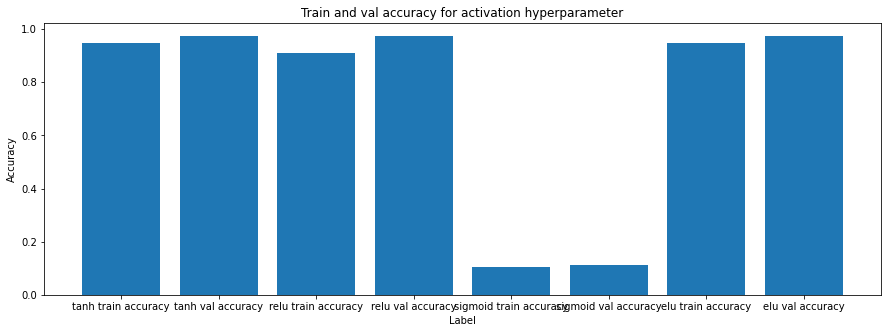

In [23]:
# Histogram
names = list(acc_dict.keys())
values = list(acc_dict.values())
fig = plt.figure(figsize=(15,5))
plt.bar(names, values)
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy for activation hyperparameter");

## Lets try grid search again eh?

In [41]:
epochs = 10 
batch_size = 32
activation_function = ['tanh', 'relu', 'elu', 'softmax', 'sigmoid']
accuracies_dict = {}
for func in activation_function:
    leNet_model = leNet_5_setup(activation_function = func)
    leNet_history = leNet_model.fit(X_train_4d, y_train_onehot, validation_data=(X_val_4d, y_val_onehot), shuffle=False, batch_size = batch_size, epochs = epochs, verbose = 1) 
    accuracies_dict[func +' train accuracy'] = leNet_history.history['accuracy'][0]
    accuracies_dict[func + 'val accuracy'] = leNet_history.history['val_accuracy'][0]

Epoch 1/10
1575/1575 [==============================] - 173s 110ms/step - loss: 0.1442 - accuracy: 0.9554 - val_loss: 0.0919 - val_accuracy: 0.9722
Epoch 2/10
1575/1575 [==============================] - 125s 79ms/step - loss: 0.0811 - accuracy: 0.9751 - val_loss: 0.0870 - val_accuracy: 0.9736
Epoch 3/10
1575/1575 [==============================] - 153s 97ms/step - loss: 0.0744 - accuracy: 0.9770 - val_loss: 0.0850 - val_accuracy: 0.9744
Epoch 4/10
1575/1575 [==============================] - 152s 97ms/step - loss: 0.0669 - accuracy: 0.9792 - val_loss: 0.0804 - val_accuracy: 0.9762
Epoch 5/10
1575/1575 [==============================] - 150s 95ms/step - loss: 0.0541 - accuracy: 0.9837 - val_loss: 0.0759 - val_accuracy: 0.9771
Epoch 6/10
1575/1575 [==============================] - 149s 94ms/step - loss: 0.0629 - accuracy: 0.9801 - val_loss: 0.0664 - val_accuracy: 0.9796
Epoch 7/10
1575/1575 [==============================] - 142s 90ms/step - loss: 0.0555 - accuracy: 0.9822 - val_loss: 

KeyboardInterrupt: 

In [ ]:
# Histogram
names = list(accuracies_dict.keys())
values = list(accuracies_dict.values())
fig = plt.figure(figsize=(15,5))
plt.bar(names, values)
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy for activation hyperparameter");

In [60]:
epochs = 20
batch_size = 32
learning_rates = [0.001, 0.01, 0.1]
accuracies_dict = {}
for l_rate in learning_rate:
    leNet_model = leNet_5_setup(activation_function = 'tanh', learning_rate = l_rate)
    leNet_history = leNet_model.fit(X_train_4d, y_train_onehot, validation_data=(X_val_4d, y_val_onehot), shuffle=False, batch_size = batch_size, epochs = epochs, verbose = 1) 
    accuracies_dict[func +' train accuracy'] = leNet_history.history['accuracy'][0]
    accuracies_dict[func + 'val accuracy'] = leNet_history.history['val_accuracy'][0]

(50400, 28, 28, 1)
(50400, 10)
Epoch 1/8
1575/1575 [==============================] - 142s 90ms/step - loss: nan - accuracy: 0.0999 - val_loss: nan - val_accuracy: 0.0952
Epoch 2/8
 946/1575 [=================>............] - ETA: 49s - loss: nan - accuracy: 0.0994

KeyboardInterrupt: 

In [92]:
epochs = 20
batch_size = 32
learning_rates = [0.001, 0.01, 0.1]
accuracies_dict = {}

kfold = KFold(n_splits=3)
acc_dict = {}
train_acc_per_fold = []
val_acc_per_fold = []
for l_rate in learning_rates:
    leNet_model = leNet_5_setup(activation_function = 'tanh', learning_rate = l_rate)
    for train_indices, test_indices in kfold.split(X_train_val_4d, y_train_val_onehot):
        X_train_set = X_train_val_4d[train_indices]
        y_train_set = y_train_val_onehot[train_indices]
        X_test_set = X_train_val_4d[test_indices]
        y_test_set = y_train_val_onehot[test_indices]
        leNet_history = leNet_model.fit(X_train_set, y_train_set, validation_data=(X_test_set, y_test_set), shuffle=False, batch_size = batch_size, epochs = epochs, verbose = 1) 
        train_acc_per_fold.append(leNet_history.history['accuracy'][-1])
        val_acc_per_fold.append(leNet_history.history['val_accuracy'][-1])
    accuracies_dict["L-rate " + str(l_rate) +' train accuracy'] = np.mean(train_acc_per_fold)
    accuracies_dict["L-rate " + str(l_rate) + ' val accuracy'] = np.mean(val_acc_per_fold)

Epoch 1/20
1313/1313 [==============================] - 146s 111ms/step - loss: 0.5005 - accuracy: 0.8823 - val_loss: 0.2995 - val_accuracy: 0.9236
Epoch 2/20
1313/1313 [==============================] - 145s 110ms/step - loss: 0.2582 - accuracy: 0.9319 - val_loss: 0.2225 - val_accuracy: 0.9425
Epoch 3/20
1313/1313 [==============================] - 137s 104ms/step - loss: 0.1990 - accuracy: 0.9467 - val_loss: 0.1793 - val_accuracy: 0.9528
Epoch 4/20
1313/1313 [==============================] - 138s 105ms/step - loss: 0.1627 - accuracy: 0.9563 - val_loss: 0.1508 - val_accuracy: 0.9609
Epoch 5/20
1313/1313 [==============================] - 134s 102ms/step - loss: 0.1390 - accuracy: 0.9630 - val_loss: 0.1330 - val_accuracy: 0.9659
Epoch 6/20
1313/1313 [==============================] - 134s 102ms/step - loss: 0.1232 - accuracy: 0.9675 - val_loss: 0.1210 - val_accuracy: 0.9680
Epoch 7/20
1313/1313 [==============================] - 135s 103ms/step - loss: 0.1121 - accuracy: 0.9705 - val_

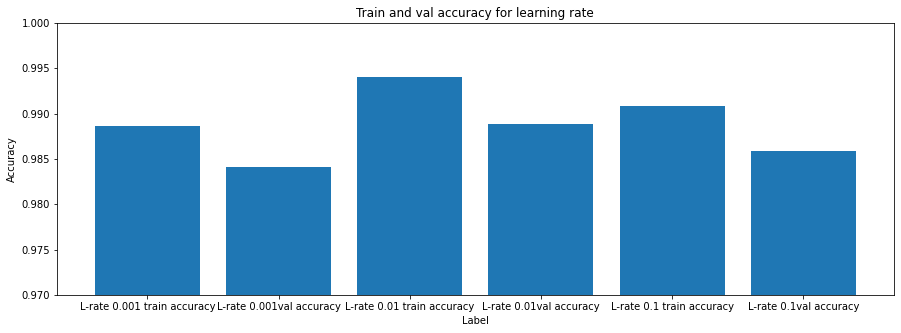

In [95]:
# Histogram
names = list(accuracies_dict.keys())
values = list(accuracies_dict.values())
fig = plt.figure(figsize=(15,5))
plt.ylim(bottom=0.97, top = 1)
plt.bar(names, values)
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy for learning rate");

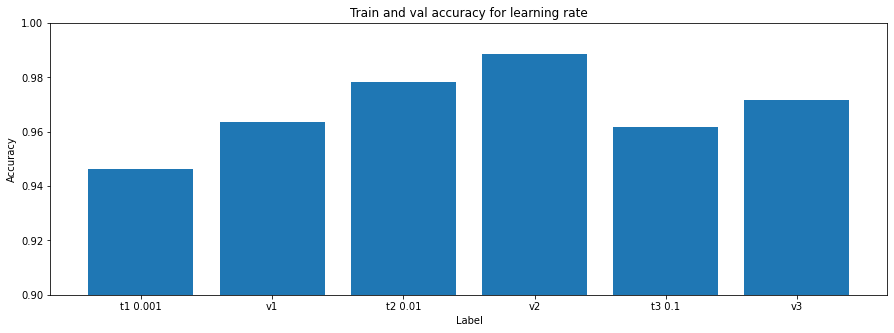

In [85]:
train_one = np.mean(train_acc_per_fold[:3])
train_two = np.mean(train_acc_per_fold[3:6])
train_three = np.mean(train_acc_per_fold[6:9])
val_one = np.mean(val_acc_per_fold[:3])
val_two = np.mean(val_acc_per_fold[3:6])
val_three = np.mean(val_acc_per_fold[6:9])
names = ['t1 0.001', 'v1', 't2 0.01', 'v2', 't3 0.1', 'v3']
values = [train_one, val_one, train_two, val_two, train_three, val_three]
fig = plt.figure(figsize=(15,5))
plt.ylim(bottom=0.90, top = 1)
plt.bar(names, values)
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy for learning rate");

In [88]:
print(train_acc_per_fold)
leNet_history.history

[0.8735476136207581, 0.979285717010498, 0.9862381219863892, 0.9474523663520813, 0.9915000200271606, 0.9955000281333923, 0.9316666722297668, 0.9732857346534729, 0.9799761772155762]


{'loss': [0.06520476937294006,
  0.07260619848966599,
  0.06144088879227638,
  0.06643263250589371,
  0.06105950474739075,
  0.05467630550265312,
  0.056033045053482056,
  0.05432874709367752,
  0.0543149895966053,
  0.05524847283959389,
  0.05491894111037254,
  0.058999430388212204,
  0.06173287704586983,
  0.05775759741663933,
  0.05400490760803223,
  0.05494597554206848,
  0.05870978534221649,
  0.053301628679037094,
  0.05928324908018112,
  0.05117126926779747],
 'accuracy': [0.9799761772155762,
  0.9764285683631897,
  0.9806666374206543,
  0.9785714149475098,
  0.9806904792785645,
  0.9828571677207947,
  0.9815714359283447,
  0.9826666712760925,
  0.9827619194984436,
  0.9821904897689819,
  0.9826904535293579,
  0.9806190729141235,
  0.9801428318023682,
  0.9814285635948181,
  0.9825476408004761,
  0.9821190237998962,
  0.9807142615318298,
  0.9825476408004761,
  0.9807618856430054,
  0.9833809733390808],
 'val_loss': [0.05313872545957565,
  0.056762583553791046,
  0.0559439249336